$\newcommand{P}{\mathbb{P}}$
$\newcommand{R}{\mathbb{R}}$
$\newcommand{Z}{\mathbb{Z}}$
$\newcommand{E}{\mathbb{E}}$
$\newcommand{x}{\mathbf{x}}$
$\newcommand{y}{\mathbf{y}}$
$\newcommand{z}{\mathbf{z}}$
$\newcommand{Norm}{\mathrm{Norm}}$
$\newcommand{\KL}[2]{D_{KL}\left[{#1}\middle\| {#2}\right]}$
$\newcommand{ELBO}{\mathcal{L}_{\theta, \varphi}(x)}$



# Variational Autoencoders
The model and its notation follows Kingma's disertation. (Thus the notation is a bit different from `EM-Algorithm-theory.ipynb` and arguably even slopier.) The presentation is heavily based on [Louis Tiao's blog](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/).

We have a Bayesian model containing random variables
The typical statistical problem comprises random variables
* $\theta$ - the unknown model variables we are interested in.
* $Z$ - the unknown latent variables we don't care about. 
Usualy the dimension increases with number of observations i.e. we have $Z_i$; $i \in \{1, \ldots, n\}$.
* $X$ - observations. Usualy composed of independent parts $X_i$.

Moreover we (pretend to) know the following probas:
* $p(\theta) := \P(\theta)$ - prior on model parameters
* $p(z):=\P(Z)$ - prior on latent variables. Usualy decomposes as $\P(Y) = \prod_i\P(Y_i)$. 
* $p_\theta(x\mid z) := \P(X\mid Z,\ \theta)$ - "likelihood". Usualy $\P(X\mid Z,\ \theta) = \prod_i \P(X_i\mid Z_i,\ \theta)$

**Remark**: This is a small simplification in comparison `EM-Algorithm-theory.ipynb` -- the prior on latent variables is fixed and does not depend on $\theta$. I think it is not significant and we don't have to assume that. However in the usual implementation of VAEs, this is the case.

### Variational inference for VAEs
#### Lower approximation of $\log \P(x\mid \theta)$
Fix a variational family $q_\varphi(z\mid x)$ of distributions on latent variables $z$.


$$
\begin{align}
\log p_\theta(x) &= \E_{q_\varphi(z\mid x)}\left[\log\frac{p_\theta(x, z)}{q_\varphi(z\mid x)}\right] + \E_{q_\varphi(z\mid x)}\left[ \log\frac{q_\varphi(z\mid x)}{p_\theta(z\mid x)} \right] =\\
&= \ELBO + \KL{q_\varphi(z\mid x)\,}{\,p_\theta(z\mid x)}
\end{align}
$$

Where $\E_{q_\varphi(z\mid x)}\left[\log\frac{p_\theta(x, z)}{q_\varphi(z\mid x)}\right] =: \ELBO $ is called "evidence lower bound" or ELBO.

#### Objective for VAE
In the original problem, we might want to find the MAP estimator of $\theta$ i.e. to maximize $ \P[\theta \mid x] \propto  p(\theta)p_\theta(x) $ wrt $\theta$. Thus in the variational approximation we maximize $\log p(\theta) + \ELBO$ wrt $\theta, \varphi$.

In the optimization, people use the following expression for ELBO:
$$\ELBO = \E_{q_\varphi(z\mid x)}\left[\log {p_\theta(x\mid z)}\right] - \KL{q_\varphi(z\mid x)\,}{\,p_\theta(z)}$$
Usualy both $q_\varphi(z\mid x)$ and $p_\theta(z)$ are Gaussians, thus the second term can be evaluated explicitly. I think people prefer this instead of the definition because when estimating it via sampling, it has lower variance. But I don't know whether it is so.

#### Encoder
$$q_\phi(\z\mid\x) = \prod_i q_\phi(\z_i\mid \x_i)$$
Where
$$q_\phi(\z_i\mid \x_i) = \Norm\left[\z_i\mid \mu_\phi(\x_i), \mathrm{diag}\left(\sigma_\phi^2(\x_i)\right) \right]$$

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as kl
import tensorflow.keras.backend as K

import numpy as np

from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as pl

from tensorflow.keras.utils import plot_model
#from IPython.display import SVG

In [2]:
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train, x_test, y_test) = [u[..., None].astype(np.float32)/255 for u in (x_train, y_train, x_test, y_test)]

In [4]:
x_train.shape, x_train.dtype

((60000, 28, 28, 1), dtype('float32'))

In [7]:
# def build_encoder(img_shape, latent_dim):
#     x = inp = kl.Input(img_shape)
#     x = kl.Conv2D(4, (3, 3), activation="relu")(x)
#     x = kl.MaxPool2D()(x)
#     x = kl.Conv2D(8, (3, 3), activation="relu")(x)
#     x = kl.MaxPool2D()(x)
#     x = kl.Flatten()(x)
    
#     mu = kl.Dense(latent_dim, activation="relu")(x)
    
#     log_var = kl.Dense(latent_dim, activation="relu")(x)
    
#     return keras.Model(inputs=inp, outputs=[mu, log_var])

def build_encoder(img_shape, latent_dim, intermediate_dim = 256):
    
    x = inp = kl.Input(shape=img_shape)
    x = kl.Flatten()(x)
    h = kl.Dense(intermediate_dim, activation='relu')(x)

    z_mu = kl.Dense(latent_dim)(h)
    z_log_var = kl.Dense(latent_dim)(h)
    return keras.Model(inp, [z_mu, z_log_var])

In [8]:
encoder = build_encoder(
    img_shape = x_train.shape[1:],
    latent_dim = 2
)

In [9]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          200960      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            514         dense_3[0][0]                    
______________________________________________________________________________________________

In [10]:
encoder(x_train[:5])

[<tf.Tensor: id=205, shape=(5, 2), dtype=float32, numpy=
 array([[-0.10622245,  0.6848679 ],
        [ 0.20929775, -0.33045852],
        [ 0.23429798, -0.51155263],
        [ 0.3063422 ,  0.04426567],
        [ 0.3082237 , -0.15488243]], dtype=float32)>,
 <tf.Tensor: id=201, shape=(5, 2), dtype=float32, numpy=
 array([[-0.2463617 ,  0.25155574],
        [-0.10468969,  0.45278692],
        [-0.34343222, -0.01106612],
        [ 0.08569366,  0.03645107],
        [ 0.18872315,  0.6835544 ]], dtype=float32)>]

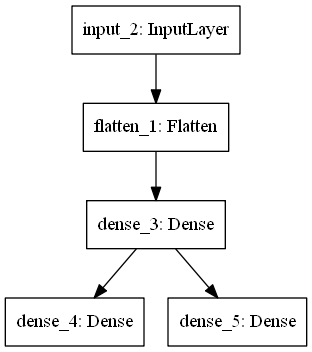

In [11]:
plot_model(encoder)

In [12]:
import tensorflow.keras.regularizers as reg

In [19]:
# def build_decoder(latent_dim, img_shape):
#     x = inp = kl.Input([latent_dim])
#     x = kl.Dense(64, kernel_regularizer=reg.l2(1e-5), activation="relu")(x)
#     x = kl.Dense(np.prod(img_shape), activation="sigmoid")(x)
#     x = kl.Reshape(img_shape)(x)
    
#     return keras.Model(inputs=inp, outputs=x)

def build_decoder(img_shape, latent_dim, intermediate_dim = 256):

    return keras.Sequential([
        kl.Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
        kl.Dense(np.prod(img_shape), activation='sigmoid'),
        kl.Reshape(img_shape)
    ])

In [20]:
decoder = build_decoder(latent_dim=2, img_shape=x_train.shape[1:])

In [21]:
x = decoder(tfd.Normal(0, 1).sample([10, 2]))
x

<tf.Tensor: id=413, shape=(10, 28, 28, 1), dtype=float32, numpy=
array([[[[0.51077366],
         [0.5025334 ],
         [0.50073105],
         ...,
         [0.50151366],
         [0.5072017 ],
         [0.50278527]],

        [[0.4964475 ],
         [0.51020914],
         [0.5005751 ],
         ...,
         [0.5088207 ],
         [0.50628984],
         [0.5017302 ]],

        [[0.497089  ],
         [0.50346375],
         [0.49220026],
         ...,
         [0.49703255],
         [0.5031325 ],
         [0.49116737]],

        ...,

        [[0.49116457],
         [0.5065324 ],
         [0.48972404],
         ...,
         [0.51555115],
         [0.5019425 ],
         [0.49947608]],

        [[0.5033738 ],
         [0.49776432],
         [0.5085329 ],
         ...,
         [0.5076323 ],
         [0.49837822],
         [0.49694142]],

        [[0.5066629 ],
         [0.50183606],
         [0.4917495 ],
         ...,
         [0.5009219 ],
         [0.5104325 ],
         [0.5005448 ]]

In [22]:
decoder.losses

[]

In [23]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, inputs):
        x = inputs
        mu, log_var = self.encoder(x)
        kl_batch = - 1/2 *  K.sum(
            1 + log_var - mu**2 - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch))
        
        sigma = tf.exp(log_var / 2)
        eps = tfd.Normal(0, 1).sample(mu.shape)
        return self.decoder(mu + sigma * eps)
        

In [24]:
vae = VAE(encoder, decoder)

In [25]:
vae(x_train)

<tf.Tensor: id=492, shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[0.5205799 ],
         [0.5022304 ],
         [0.5067776 ],
         ...,
         [0.49773127],
         [0.51655924],
         [0.50339097]],

        [[0.49211887],
         [0.521359  ],
         [0.50347424],
         ...,
         [0.51382416],
         [0.5125198 ],
         [0.5007136 ]],

        [[0.50093603],
         [0.5177573 ],
         [0.48560604],
         ...,
         [0.49324083],
         [0.5182523 ],
         [0.47831127]],

        ...,

        [[0.4818416 ],
         [0.5084122 ],
         [0.47569558],
         ...,
         [0.5245856 ],
         [0.50606155],
         [0.49370295]],

        [[0.5101913 ],
         [0.50003535],
         [0.5249921 ],
         ...,
         [0.5206972 ],
         [0.490722  ],
         [0.49749917]],

        [[0.51051384],
         [0.50169283],
         [0.481861  ],
         ...,
         [0.5021418 ],
         [0.52155966],
         [0.5062001

In [26]:
vae.losses

[<tf.Tensor: id=443, shape=(), dtype=float32, numpy=0.16950332>]

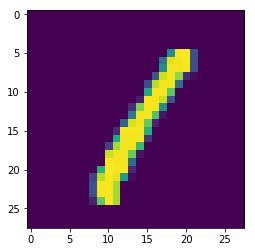

In [27]:
pl.imshow(x_train[3].squeeze())

In [28]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    lh = tfd.Bernoulli(probs=y_pred)
    return - K.sum(lh.log_prob(y_true), axis=(-1, -2, -3))

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss_metric = tf.keras.metrics.Mean()

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Iterate over epochs.
for epoch in range(300):
    print('Start of epoch %d' % (epoch,))
    loss_metric.reset_states()
    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            loss = nll(x_batch_train, vae(x_batch_train))
            loss += sum(vae.losses)  # Add KLD regularization loss and priors

        grads = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))

        loss_metric(loss)

    print('mean loss =', loss_metric.result())

Start of epoch 0
mean loss = tf.Tensor(nan, shape=(), dtype=float32)
Start of epoch 1


KeyboardInterrupt: 

In [ ]:
def loss

In [82]:
vae.compile(optimizer='adam', loss=nll)

In [87]:
vae.fit(
    x_train, x_train, 
    shuffle = True, epochs=10, 
)#validation_data=(x_test, y_test))

AttributeError: 'VAE' object has no attribute '_feed_output_names'

In [89]:
len(vae.trainable_variables)

14

In [106]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Iterate over epochs.
for epoch in range(300):
    print('Start of epoch %d' % (epoch,))
    loss_metric.reset_states()
    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))

        loss_metric(loss)

    print('mean loss =', loss_metric.result())

Start of epoch 0
mean loss = tf.Tensor(0.7864496, shape=(), dtype=float32)
Start of epoch 1
mean loss = tf.Tensor(0.78644305, shape=(), dtype=float32)
Start of epoch 2
mean loss = tf.Tensor(0.78644305, shape=(), dtype=float32)
Start of epoch 3
mean loss = tf.Tensor(0.78644305, shape=(), dtype=float32)
Start of epoch 4
mean loss = tf.Tensor(0.786443, shape=(), dtype=float32)
Start of epoch 5


KeyboardInterrupt: 

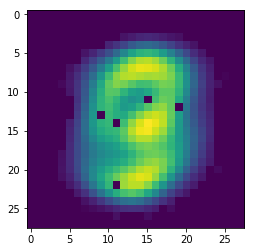

In [105]:
s = decoder(tfd.Normal(0, 1).sample([1, 2])).numpy().reshape([28, 28])
pl.imshow(s)

In [93]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=3, batch_size=64)

AttributeError: 'VAE' object has no attribute '_feed_output_names'

In [97]:
vae._is_graph_network

False

D:\python_projects\workon_bayes\WPy-3662\python-3.6.6.amd64\lib\site-packages\matplotlib\image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
D:\python_projects\workon_bayes\WPy-3662\python-3.6.6.amd64\lib\site-packages\matplotlib\image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
D:\python_projects\workon_bayes\WPy-3662\python-3.6.6.amd64\lib\site-packages\matplotlib\image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
D:\python_projects\workon_bayes\WPy-3662\python-3.6.6.amd64\lib\site-packages\matplotlib\image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
D:\python_projects\workon_bayes\WPy-3662\python-3.6.6.amd64\lib\site-packages\matplotlib\colors.py:902: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
D:\python_projects\workon_bayes\W

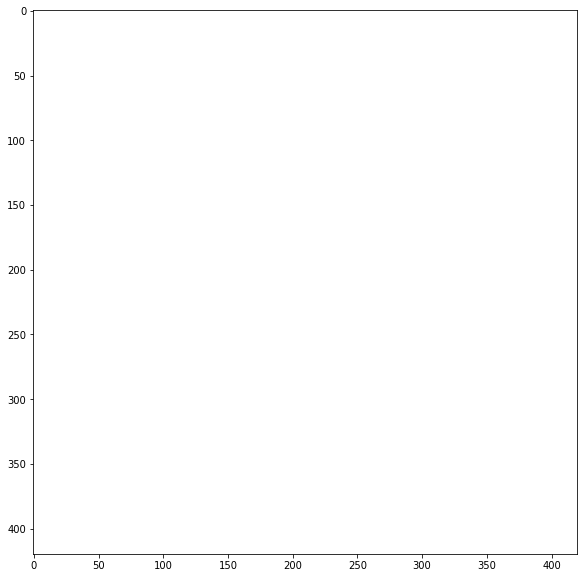

In [24]:
from scipy.stats import norm
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

pl.figure(figsize=(10, 10))
pl.imshow(np.block(list(map(list, x_decoded))), cmap='gray')

In [25]:
x_decoded

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan